# 1. Perkenalan

**Nama**    : **Ahmad Qais Alfiansyah**<br>
**Batch**   : **RMT-027**<br>
**Project** : **Live Code 4**<br>

<hr>

## **Latar Belakang Masalah**
<p> Saya sedangn mencari asuransi, tetapi sebelumnya saya akan cek berapa perkiraan harga, berdasarkan data yang sudah ada.<br>
Dataset yang digunakan adalah data pengguna asuransi sebelumnya. Dan saya akan memprediksi dengan menggunakan LinearRegression</p>

# 2. Import Libraries

In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

import pickle

In [214]:
# df = pd.read_csv('https://raw.githubusercontent.com/FTDS-assignment-bay/p1-ftds027-rmt-lc4-qaisahmaddd/main/insurance.csv?token=GHSAT0AAAAAACLA4D4PTC5TLXIVEH6KNRNAZNN2ZGQ')
df = pd.read_csv('/content/insurance.csv')

# 3. Data Loading

## Menampilkan 10 baris pertama dataset

In [215]:
df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


Terlihat bahwaterdapat beberapa jenis tipe data pada kolom, terdapat juga kolom berupa boolean Yes/No pada kolom 'Smoker'. Selanjutnya saya akan cek tipe data setiap kolom

## Menampilkan informasi Dataset

In [216]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Tipe data sudah sesuai, dimana yang seharusnya numerik bertipe INT atau FLOAT. Selanjutnya saya akan cek kardinalitas pada tipe data object

## Cek Cardinality

In [217]:
cat_col = df.select_dtypes(include = 'object')
cat_col.nunique()

sex       2
smoker    2
region    4
dtype: int64

Terlihat bahwa data kategori kardinalitasnya rendah. Sehingga sepertinya semua bisa dimasukkan kedalam model

## Cek Missing Value

In [218]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Terlihat bahwa tidak ada nilai yang hilang pada dataset

#4. Exploratory Data Analysis (EDA)

## Buat Kolom Baru

Buat kolom overweight berdasarkan class-nya.

overweight class 1 : 30 ≤ BMI < 35

overweight class 2 : 35 ≤ BMI < 40

overweight class 3 : BMI ≥ 40

Sebelumnya saya akan cek nilai Max dan Min dari kolom BMI

### Cek nilai Min dan Max

In [219]:
print(f"Nilai BMI terendah dalam data adalah: {df['bmi'].min()}")
print(f"Nilai BMI tertinggi dalam data adalah: {df['bmi'].max()}")

Nilai BMI terendah dalam data adalah: 15.96
Nilai BMI tertinggi dalam data adalah: 53.13


Seperti kita ketahui bahwa BMI terendah sampai 15.96, maka saya putuskan untuk kategori di bawah 30 overweight class = 0. Sehingga nanti bisa dipergunakan apakah bisa dianggap sebagai outliers atau tidak

### Eksekusi Kolom

In [220]:
overweight_class = []
for x in df['bmi'].values:
  if x >= 40:
    overweight_class.append(3)
  elif (x < 40) and (x >= 35):
    overweight_class.append(2)
  elif (x < 35) and (x >= 30):
    overweight_class.append(1)
  else:
    overweight_class.append(0)
df['overweight_class'] = overweight_class
df

,age,sex,bmi,children,smoker,region,charges,overweight_class
0,19,female,27.900,0,yes,southwest,16884.92400,0
1,18,male,33.770,1,no,southeast,1725.55230,1
2,28,male,33.000,3,no,southeast,4449.46200,1
3,33,male,22.705,0,no,northwest,21984.47061,0
4,32,male,28.880,0,no,northwest,3866.85520,0
...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,1
1334,18,female,31.920,0,no,northeast,2205.98080,1
1335,18,female,36.850,0,no,southeast,1629.83350,2
1336,21,female,25.800,0,no,southwest,2007.94500,0


Selanjutnya saya akan menghitung jumlah nilai overwight_class

In [221]:
hitung_overweight = df['overweight_class'].value_counts().sort_values(ascending= False)
hitung_overweight

0    631
1    391
2    225
3     91
Name: overweight_class, dtype: int64

Terlihat bawha terdapat sangat banyak observasi yang nilainya di bawah keterangan di atas. Dan berdasarkan informasi mengenai rentang BMI yang ada, maka saya tidak anggap sebagai outliers

### Grafik Peserta Overwight Class


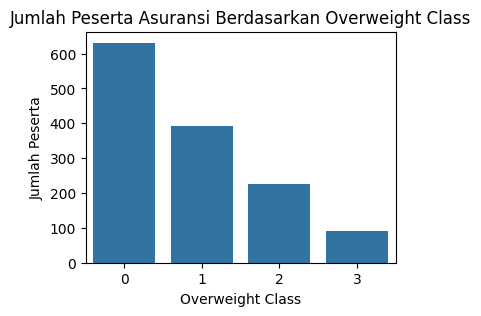

In [222]:
plt.figure(figsize=(4,3))
sns.barplot(x= hitung_overweight.index, y=hitung_overweight.values)
plt.title('Jumlah Peserta Asuransi Berdasarkan Overweight Class')
plt.xlabel('Overweight Class')
plt.ylabel('Jumlah Peserta')
plt.show()


### Hubungan Antara Biaya Asuransi, BMI, dan status Merokok


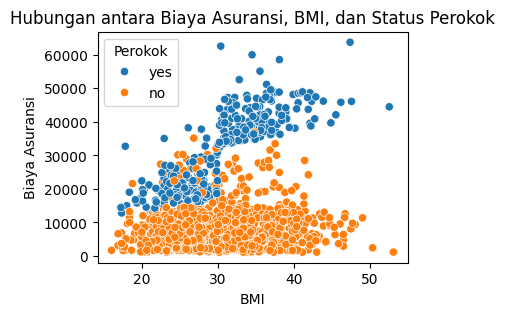

In [223]:
plt.figure(figsize= (4, 3))
sns.scatterplot(data= df, x= 'bmi', y= 'charges', hue= 'smoker')
plt.title('Hubungan antara Biaya Asuransi, BMI, dan Status Perokok')
plt.xlabel('BMI')
plt.ylabel('Biaya Asuransi')
plt.legend(title = 'Perokok')
plt.show()

Dari grafik di atas, saya berasumsi sangat kuat bahwa:
1. Perokok mendapatkan biaya asuransi lebih tingi dibandingkan non perokok
2. Perokok yang memiliki BMI tinggi dikenakan biaya asuransi yang lebih tinggi lagi
3. Berbeda dengan BMI non perokok. Tinggi rendahnya BMI tidak mempengaruhi biaya asuransi

## Gambaran Statistika Data

In [224]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801
overweight_class,1338.0,0.832586,0.940448,0.0000,0.00000,1.000,1.000000,3.00000


In [225]:
df.select_dtypes(include= 'object').describe().transpose()

,count,unique,top,freq
sex,1338,2,male,676
smoker,1338,2,no,1064
region,1338,4,southeast,364


## Cek Distribusi Data

Sebelumnya saya akan memisahkan tipe data object dan numerikal. Karena ini akan mempengaruhi plot yang akan digunakan

In [226]:
cat_col = df.select_dtypes(include = 'object')
num_col = df.select_dtypes(exclude = 'object')

### Distribusi Data Kolom Object

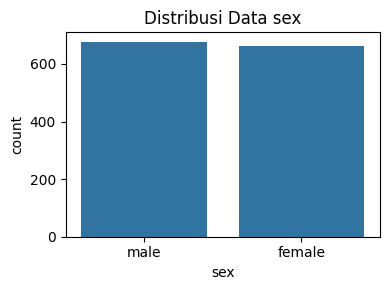

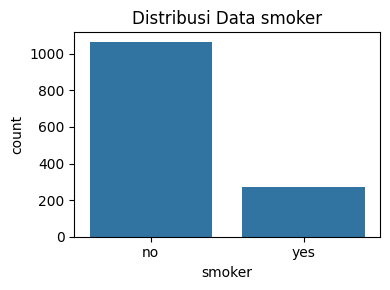

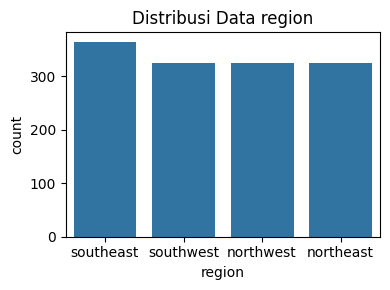

In [227]:
for kolom in cat_col:
  plt.figure(figsize= (4,3))
  ax = sns.countplot(x= kolom, data = cat_col, order= cat_col[kolom].value_counts().index)
  plt.title(f'Distribusi Data {kolom}')
  plt.xlabel(kolom)
  plt.tight_layout()
  plt.show()
  print('\n')

### Distribusi Data Kolom Int dan Float

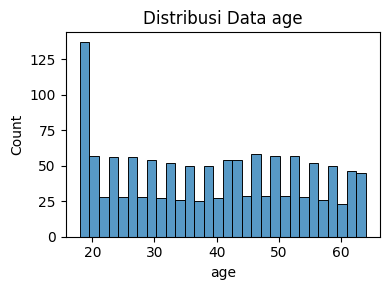

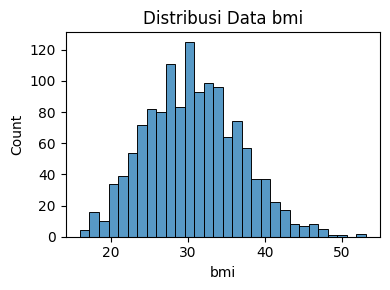

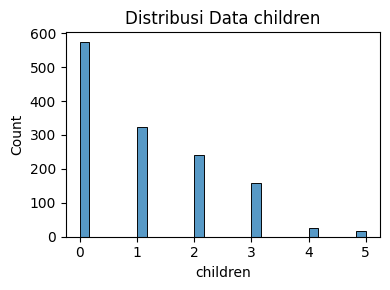

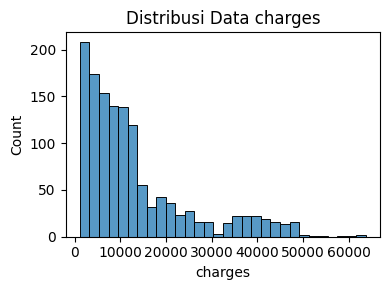

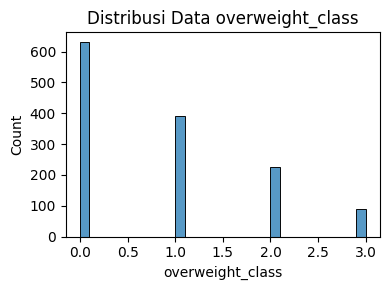

In [228]:
for kolom in num_col:
  plt.figure(figsize= (4,3))
  ax = sns.histplot(x= kolom, data = num_col, bins= 30)
  plt.title(f'Distribusi Data {kolom}')
  plt.xlabel(kolom)
  plt.tight_layout()
  plt.show()
  print('\n')

Dari sini terlihat age dan bmi sangat ideal

## Cek Outliers

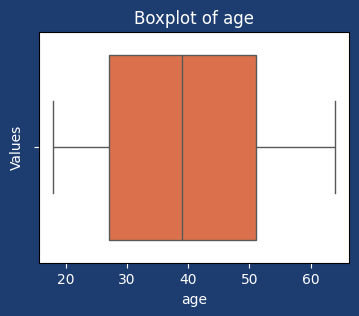

Nilai maksimum untuk age: 64
Nilai minimum untuk age: 18
Batas atas outlier untuk age: 87.0
Batas bawah outlier untuk age: -9.0



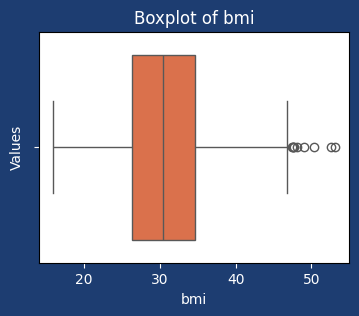

Nilai maksimum untuk bmi: 53.13
Nilai minimum untuk bmi: 15.96
Batas atas outlier untuk bmi: 47.290000000000006
Batas bawah outlier untuk bmi: 13.7



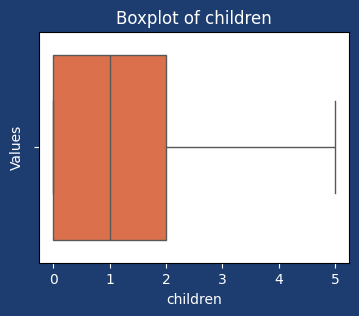

Nilai maksimum untuk children: 5
Nilai minimum untuk children: 0
Batas atas outlier untuk children: 5.0
Batas bawah outlier untuk children: -3.0



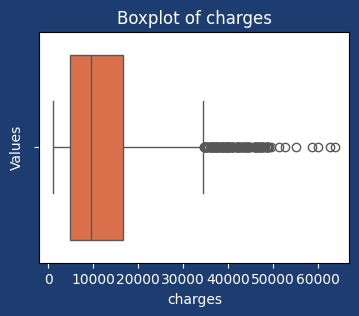

Nilai maksimum untuk charges: 63770.42801
Nilai minimum untuk charges: 1121.8739
Batas atas outlier untuk charges: 34489.350562499996
Batas bawah outlier untuk charges: -13109.1508975



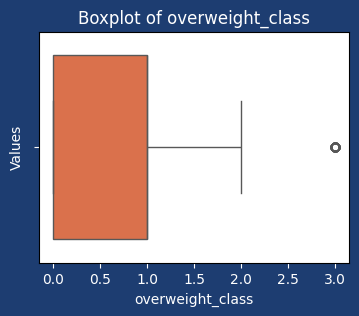

Nilai maksimum untuk overweight_class: 3
Nilai minimum untuk overweight_class: 0
Batas atas outlier untuk overweight_class: 2.5
Batas bawah outlier untuk overweight_class: -1.5



In [229]:
for kolom in num_col:
  Q1 = num_col[kolom].quantile(0.25)
  Q3 = num_col[kolom].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  plt.figure(figsize=(4, 3), facecolor='#1D3D71')
  sns.boxplot(x=num_col[kolom], color='#F26634')
  ax.set_facecolor('#1D3D71')
  plt.title(f'Boxplot of {kolom}', color='white')
  plt.xlabel(kolom, color='white')
  plt.ylabel('Values', color='white')
  plt.tick_params(colors='white')
  plt.show()

  print(f'Nilai maksimum untuk {kolom}: {num_col[kolom].max()}')
  print(f'Nilai minimum untuk {kolom}: {num_col[kolom].min()}')
  print(f'Batas atas outlier untuk {kolom}: {upper_bound}')
  print(f'Batas bawah outlier untuk {kolom}: {lower_bound}\n')

BMI dan charges terlihat terdapat outliers. Dengan pernyataan sebelumnya, charge dipengaruhi dengan status merokok. Dan BMI memang sewajarnya manusia ada di range tersebut, maka saya tidak akan hapus outliers

## Hitung Korelasi Antar Kolom (Fitur)

<ipython-input-230-b6378eae64f4>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


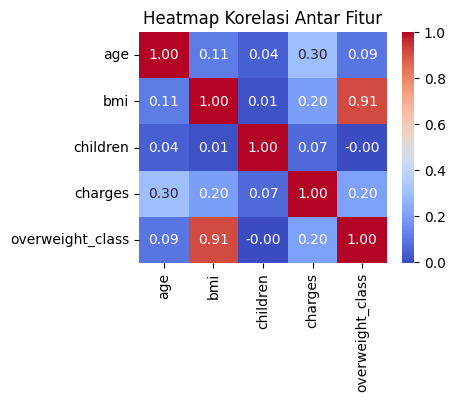

In [230]:
# Hitung matriks korelasi
correlation_matrix = df.corr()

# Buat heatmap untuk memvisualisasikan matriks korelasi
plt.figure(figsize=(4, 3))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Heatmap Korelasi Antar Fitur')
plt.show()

Rerlihat bahwa kepemilikan anak tidak relevan. Tetapi saya tidak akan hapus kolom tersebut. Jadi dibiarkan natural saja

#5 Feature Engineering

In [233]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1338 non-null   int64  
 1   sex               1338 non-null   object 
 2   bmi               1338 non-null   float64
 3   children          1338 non-null   int64  
 4   smoker            1338 non-null   object 
 5   region            1338 non-null   object 
 6   charges           1338 non-null   float64
 7   overweight_class  1338 non-null   int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 83.8+ KB


### Encoded Data

In [235]:
col_encode = ['sex', 'religion', 'smoker']
ct = ColumnTransformer([('onehot', onehot_encoder, col_encode)]remainder = 'passthrough')

encoded = ct.fit_transform(df)

gf = ct.named_transformers_['onehot'].get_feature_namesout(col_encode)
others = [name for name in df.columns if name not in col_encode

all = list(gf) + other_feature_names] + others

df_encoded = pd.DataFrame(encoded, columsn = all)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (<ipython-input-235-a10bf5cf8903>, line 2)

In [231]:
X = df.drop('charges', axis=1)

In [232]:
y = df['charges']

In [211]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print('Train size : ', X_train.shape)
print('Test size  : ', X_test.shape)

Train size :  (936, 7)
Test size  :  (402, 7)


### Encode Fitur

In [171]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled

ValueError: could not convert string to float: 'female'

#6. Model Definition

Saya akan menggunakan model Linear Regression

# 7. Model Train

# 8. Model Evaluation

# 9. Model Saving

# 10. Model Inference

# 11. Pengambilan Keputusan